# Phase 4: Advanced Models & Ensembles

This notebook implements advanced models and ensemble methods to achieve target performance.

**Objectives:**
- Train tuned LightGBM with optimized hyperparameters
- Train XGBoost model
- Train CatBoost model
- Create weighted ensemble
- Compare all models (baseline + advanced)
- Analyze feature importance
- Evaluate gap to target RMSPE (0.09856)

**CRITICAL:** All experiments tracked with MLflow for reproducibility.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import mlflow
from datetime import datetime
from scipy.optimize import minimize

from evaluation.cv import (
    make_time_series_folds,
    filter_open_stores,
    remove_missing_features
)
from evaluation.metrics import rmspe
from evaluation.reporting import (
    print_cv_summary,
    compare_models
)
from utils.io import read_parquet
from utils.mlflow_utils import setup_mlflow, log_params_from_dict, log_dvc_data_version

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Setup MLflow
experiment_id = setup_mlflow()
print(f"MLflow experiment ID: {experiment_id}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print("\nSetup complete!")

MLflow experiment ID: 211292085284843771
MLflow tracking URI: /Users/b294776/Desktop/Projects/rossmann-forecasting/mlruns

Setup complete!


/Users/b294776/Desktop/Projects/rossmann-forecasting/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


## 1. Load Data and Create CV Folds

In [2]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


In [3]:
# Load CV config
with open('../config/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

cv_config = params['cv']

print("Cross-Validation Configuration:")
print(f"  N folds: {cv_config['n_folds']}")
print(f"  Fold length: {cv_config['fold_length_days']} days")

Cross-Validation Configuration:
  N folds: 5
  Fold length: 42 days


In [4]:
# Filter and create folds
df_open = filter_open_stores(df)

folds = make_time_series_folds(
    df_open,
    n_folds=cv_config['n_folds'],
    fold_length_days=cv_config['fold_length_days'],
    min_train_days=cv_config['min_train_days']
)

# Define feature columns
exclude_cols = ['Sales', 'Date', 'Store', 'Customers']
feature_cols = [col for col in df_open.columns if col not in exclude_cols]

print(f"Created {len(folds)} folds")
print(f"Features: {len(feature_cols)}")

2025-12-15 10:54:38 - evaluation.cv - INFO - Filtered out 172,817 closed store-days (16.99%)
2025-12-15 10:54:38 - evaluation.cv - INFO - Remaining: 844,392 open store-days
2025-12-15 10:54:38 - evaluation.cv - INFO - ============================================================
2025-12-15 10:54:38 - evaluation.cv - INFO - Creating time-series cross-validation folds
2025-12-15 10:54:38 - evaluation.cv - INFO - ============================================================
2025-12-15 10:54:38 - evaluation.cv - INFO - Number of folds: 5
2025-12-15 10:54:38 - evaluation.cv - INFO - Validation fold length: 42 days (6 weeks)
2025-12-15 10:54:38 - evaluation.cv - INFO - Minimum training days: 365 days (1 year)
2025-12-15 10:54:38 - evaluation.cv - INFO - Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
2025-12-15 10:54:38 - evaluation.cv - INFO - Total unique dates: 942
2025-12-15 10:54:38 - evaluation.cv - INFO - 
First validation period starts at: 2014-01-01 00:00:00
2025-12-15 10:54:38

## 2. Train Tuned LightGBM Model

Train LightGBM with optimized hyperparameters from params.yaml.

**Tracked in MLflow:** All hyperparameters, per-fold metrics, and summary statistics.

In [5]:
# Start MLflow run for tuned LightGBM
with mlflow.start_run(run_name="lightgbm_tuned") as run:
    print("="*60)
    print("Training Tuned LightGBM Model")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Load LightGBM parameters from config
    lgb_config = params["models"]["advanced_lightgbm"]
    
    # Extract parameters
    num_boost_round = lgb_config.pop("num_boost_round", 2000)
    early_stopping_rounds = lgb_config.pop("early_stopping_rounds", 100)
    
    lgb_params = lgb_config.copy()
    lgb_params['verbose'] = -1
    lgb_params['seed'] = 42
    
    # Log model metadata
    mlflow.log_param("model_type", "lightgbm")
    mlflow.log_param("model_variant", "tuned")
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("num_boost_round", num_boost_round)
    mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
    
    # Log all LightGBM parameters
    log_params_from_dict(lgb_params, prefix="lgb")
    
    print(f"Number of features: {len(feature_cols)}")
    print(f"Parameters: {lgb_params}")
    
    # Train on each fold
    fold_scores = []
    fold_times = []
    trained_models = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds, 1):
        # Get train/val data
        train_data = df_open.iloc[train_idx]
        val_data = df_open.iloc[val_idx]
        
        # Remove rows with missing features
        train_data, _ = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, feature_cols)
        
        # Prepare features and target
        X_train = train_data[feature_cols]
        y_train = train_data['Sales']
        X_val = val_data[feature_cols]
        y_val = val_data['Sales']
        
        print(f"\nFold {fold_idx}:")
        print(f"  Train size: {len(X_train):,}")
        print(f"  Val size: {len(X_val):,}")
        
        # Create LightGBM datasets
        train_dataset = lgb.Dataset(X_train, y_train)
        val_dataset = lgb.Dataset(X_val, y_val, reference=train_dataset)
        
        # Train model
        start_time = datetime.now()
        model = lgb.train(
            lgb_params,
            train_dataset,
            num_boost_round=num_boost_round,
            valid_sets=[val_dataset],
            valid_names=['validation'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        train_time = (datetime.now() - start_time).total_seconds()
        fold_times.append(train_time)
        trained_models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        
        # Calculate RMSPE
        score = rmspe(y_val, y_pred)
        fold_scores.append(score)
        
        # Log fold metrics
        mlflow.log_metric(f"rmspe_fold_{fold_idx}", score)
        mlflow.log_metric(f"train_time_fold_{fold_idx}", train_time)
        mlflow.log_metric(f"best_iteration_fold_{fold_idx}", model.best_iteration)
        
        print(f"  Best iteration: {model.best_iteration}")
        print(f"  RMSPE: {score:.6f}")
        print(f"  Training time: {train_time:.2f}s")
    
    # Calculate summary statistics
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    mean_time = np.mean(fold_times)
    
    # Log summary metrics
    mlflow.log_metric("rmspe_mean", mean_score)
    mlflow.log_metric("rmspe_std", std_score)
    mlflow.log_metric("rmspe_min", np.min(fold_scores))
    mlflow.log_metric("rmspe_max", np.max(fold_scores))
    mlflow.log_metric("mean_train_time", mean_time)
    mlflow.log_metric("total_train_time", sum(fold_times))
    
    print(f"\nMean RMSPE: {mean_score:.6f} ± {std_score:.6f}")
    print(f"Mean training time: {mean_time:.2f}s")
    print("="*60)
    
    # Store results for later comparison
    lgb_tuned_results = {
        'model_name': 'LightGBM_Tuned',
        'mean_score': mean_score,
        'std_score': std_score,
        'fold_scores': fold_scores,
        'metric': 'RMSPE',
        'models': trained_models,
        'features': feature_cols
    }
    
    print(f"\nMLflow Run ID: {run.info.run_id}")

Training Tuned LightGBM Model
Number of features: 46
Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 50, 'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'max_depth': 8, 'min_child_samples': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'verbose': -1, 'seed': 42}
2025-12-15 10:54:38 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 10:54:38 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 10:54:38 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 10:54:38 - evaluation.cv - INFO - Remaining: 38,761 complete rows

Fold 1:
  Train size: 312,396
  Val size: 38,761
  Best iteration: 409
  RMSPE: 0.164662
  Training time: 6.68s
2025-12-15 10:54:45 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 10:54:45 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 10:54:45 - e

In [6]:
# Display CV summary
print_cv_summary(lgb_tuned_results)

LightGBM_Tuned - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.164662
  Fold 2: 0.165565
  Fold 3: 0.118949
  Fold 4: 0.117823
  Fold 5: 0.115002

Mean RMSPE: 0.136400
Std  RMSPE: 0.023481
CV Range: [0.112919, 0.159881]


## 3. Train XGBoost Model

Train XGBoost with optimized hyperparameters.

**Tracked in MLflow:** All hyperparameters, per-fold metrics, and summary statistics.

In [7]:
# Start MLflow run for XGBoost
with mlflow.start_run(run_name="xgboost") as run:
    print("="*60)
    print("Training XGBoost Model")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Load XGBoost parameters from config
    xgb_config = params["models"]["advanced_xgboost"]
    
    # Extract parameters
    num_boost_round = xgb_config.pop("num_boost_round", 2000)
    early_stopping_rounds = xgb_config.pop("early_stopping_rounds", 100)
    
    xgb_params = xgb_config.copy()
    xgb_params['seed'] = 42
    xgb_params['verbosity'] = 0
    
    # Log model metadata
    mlflow.log_param("model_type", "xgboost")
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("num_boost_round", num_boost_round)
    mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
    
    # Log all XGBoost parameters
    log_params_from_dict(xgb_params, prefix="xgb")
    
    print(f"Number of features: {len(feature_cols)}")
    print(f"Parameters: {xgb_params}")
    
    # Train on each fold
    fold_scores = []
    fold_times = []
    trained_models = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds, 1):
        # Get train/val data
        train_data = df_open.iloc[train_idx]
        val_data = df_open.iloc[val_idx]
        
        # Remove rows with missing features
        train_data, _ = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, feature_cols)
        
        # Prepare features and target
        X_train = train_data[feature_cols].copy()
        y_train = train_data['Sales']
        X_val = val_data[feature_cols].copy()
        y_val = val_data['Sales']
        
        # Convert categorical columns to numeric (XGBoost requirement)
        for col in X_train.columns:
            if X_train[col].dtype.name == 'category':
                X_train[col] = X_train[col].cat.codes
                X_val[col] = X_val[col].cat.codes
        
        print(f"\nFold {fold_idx}:")
        print(f"  Train size: {len(X_train):,}")
        print(f"  Val size: {len(X_val):,}")
        
        # Create DMatrix
        dtrain = xgb.DMatrix(X_train, y_train)
        dval = xgb.DMatrix(X_val, y_val)
        
        # Train model
        start_time = datetime.now()
        evals = [(dval, 'validation')]
        model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        train_time = (datetime.now() - start_time).total_seconds()
        fold_times.append(train_time)
        trained_models.append(model)
        
        # Make predictions
        y_pred = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        
        # Calculate RMSPE
        score = rmspe(y_val, y_pred)
        fold_scores.append(score)
        
        # Log fold metrics
        mlflow.log_metric(f"rmspe_fold_{fold_idx}", score)
        mlflow.log_metric(f"train_time_fold_{fold_idx}", train_time)
        mlflow.log_metric(f"best_iteration_fold_{fold_idx}", model.best_iteration)
        
        print(f"  Best iteration: {model.best_iteration}")
        print(f"  RMSPE: {score:.6f}")
        print(f"  Training time: {train_time:.2f}s")
    
    # Calculate summary statistics
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    mean_time = np.mean(fold_times)
    
    # Log summary metrics
    mlflow.log_metric("rmspe_mean", mean_score)
    mlflow.log_metric("rmspe_std", std_score)
    mlflow.log_metric("rmspe_min", np.min(fold_scores))
    mlflow.log_metric("rmspe_max", np.max(fold_scores))
    mlflow.log_metric("mean_train_time", mean_time)
    mlflow.log_metric("total_train_time", sum(fold_times))
    
    print(f"\nMean RMSPE: {mean_score:.6f} ± {std_score:.6f}")
    print(f"Mean training time: {mean_time:.2f}s")
    print("="*60)
    
    # Store results for later comparison
    xgb_results = {
        'model_name': 'XGBoost',
        'mean_score': mean_score,
        'std_score': std_score,
        'fold_scores': fold_scores,
        'metric': 'RMSPE',
        'models': trained_models
    }
    
    print(f"\nMLflow Run ID: {run.info.run_id}")

Training XGBoost Model
Number of features: 46
Parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 8, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'seed': 42, 'verbosity': 0}
2025-12-15 10:55:54 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 10:55:54 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 10:55:54 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 10:55:54 - evaluation.cv - INFO - Remaining: 38,761 complete rows

Fold 1:
  Train size: 312,396
  Val size: 38,761
  Best iteration: 230
  RMSPE: 0.153042
  Training time: 2.21s
2025-12-15 10:55:57 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 10:55:57 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 10:55:57 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)

In [8]:
# Display CV summary
print_cv_summary(xgb_results)

XGBoost - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.153042
  Fold 2: 0.160474
  Fold 3: 0.114235
  Fold 4: 0.114040
  Fold 5: 0.111198

Mean RMSPE: 0.130598
Std  RMSPE: 0.021516
CV Range: [0.109082, 0.152114]


## 4. Train CatBoost Model

Train CatBoost which handles categorical features natively.

**Tracked in MLflow:** All hyperparameters, per-fold metrics, and summary statistics.

In [9]:
# Start MLflow run for CatBoost
with mlflow.start_run(run_name="catboost") as run:
    print("="*60)
    print("Training CatBoost Model")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Load CatBoost parameters from config
    cb_config = params["models"]["advanced_catboost"]
    
    # Extract parameters
    iterations = cb_config.pop("iterations", 2000)
    early_stopping_rounds = cb_config.pop("early_stopping_rounds", 100)
    
    cb_params = cb_config.copy()
    cb_params['random_seed'] = 42
    cb_params['verbose'] = False
    
    # Identify categorical features
    cat_features = [col for col in feature_cols if df_open[col].dtype.name == 'category']
    
    # Log model metadata
    mlflow.log_param("model_type", "catboost")
    mlflow.log_param("n_features", len(feature_cols))
    mlflow.log_param("n_categorical_features", len(cat_features))
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("iterations", iterations)
    mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
    
    # Log all CatBoost parameters
    log_params_from_dict(cb_params, prefix="cb")
    
    print(f"Number of features: {len(feature_cols)}")
    print(f"Categorical features: {len(cat_features)}")
    print(f"Parameters: {cb_params}")
    
    # Train on each fold
    fold_scores = []
    fold_times = []
    trained_models = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds, 1):
        # Get train/val data
        train_data = df_open.iloc[train_idx]
        val_data = df_open.iloc[val_idx]
        
        # Remove rows with missing features
        train_data, _ = remove_missing_features(train_data, feature_cols)
        val_data, _ = remove_missing_features(val_data, feature_cols)
        
        # Prepare features and target
        X_train = train_data[feature_cols]
        y_train = train_data['Sales']
        X_val = val_data[feature_cols]
        y_val = val_data['Sales']
        
        print(f"\nFold {fold_idx}:")
        print(f"  Train size: {len(X_train):,}")
        print(f"  Val size: {len(X_val):,}")
        
        # Create Pool objects
        train_pool = cb.Pool(X_train, y_train, cat_features=cat_features)
        val_pool = cb.Pool(X_val, y_val, cat_features=cat_features)
        
        # Train model
        start_time = datetime.now()
        model = cb.CatBoostRegressor(
            iterations=iterations,
            **cb_params
        )
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=early_stopping_rounds,
            verbose=False
        )
        train_time = (datetime.now() - start_time).total_seconds()
        fold_times.append(train_time)
        trained_models.append(model)
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # Calculate RMSPE
        score = rmspe(y_val, y_pred)
        fold_scores.append(score)
        
        # Log fold metrics
        mlflow.log_metric(f"rmspe_fold_{fold_idx}", score)
        mlflow.log_metric(f"train_time_fold_{fold_idx}", train_time)
        mlflow.log_metric(f"best_iteration_fold_{fold_idx}", model.best_iteration_)
        
        print(f"  Best iteration: {model.best_iteration_}")
        print(f"  RMSPE: {score:.6f}")
        print(f"  Training time: {train_time:.2f}s")
    
    # Calculate summary statistics
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    mean_time = np.mean(fold_times)
    
    # Log summary metrics
    mlflow.log_metric("rmspe_mean", mean_score)
    mlflow.log_metric("rmspe_std", std_score)
    mlflow.log_metric("rmspe_min", np.min(fold_scores))
    mlflow.log_metric("rmspe_max", np.max(fold_scores))
    mlflow.log_metric("mean_train_time", mean_time)
    mlflow.log_metric("total_train_time", sum(fold_times))
    
    print(f"\nMean RMSPE: {mean_score:.6f} ± {std_score:.6f}")
    print(f"Mean training time: {mean_time:.2f}s")
    print("="*60)
    
    # Store results for later comparison
    cb_results = {
        'model_name': 'CatBoost',
        'mean_score': mean_score,
        'std_score': std_score,
        'fold_scores': fold_scores,
        'metric': 'RMSPE',
        'models': trained_models
    }
    
    print(f"\nMLflow Run ID: {run.info.run_id}")

Training CatBoost Model
Number of features: 46
Categorical features: 4
Parameters: {'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'depth': 8, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'random_strength': 0.5, 'bagging_temperature': 0.2, 'border_count': 128, 'random_seed': 42, 'verbose': False}
2025-12-15 10:56:46 - evaluation.cv - INFO - Removed 25,547 rows with missing features (7.56%)
2025-12-15 10:56:46 - evaluation.cv - INFO - Remaining: 312,396 complete rows
2025-12-15 10:56:46 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 10:56:46 - evaluation.cv - INFO - Remaining: 38,761 complete rows

Fold 1:
  Train size: 312,396
  Val size: 38,761
  Best iteration: 175
  RMSPE: 0.174635
  Training time: 11.44s
2025-12-15 10:56:57 - evaluation.cv - INFO - Removed 25,547 rows with missing features (6.78%)
2025-12-15 10:56:57 - evaluation.cv - INFO - Remaining: 351,157 complete rows
2025-12-15 10:56:57 - evaluation.cv - INFO - Removed 0 rows with missing featu

In [10]:
# Display CV summary
print_cv_summary(cb_results)

CatBoost - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.174635
  Fold 2: 0.165841
  Fold 3: 0.111157
  Fold 4: 0.116131
  Fold 5: 0.112610

Mean RMSPE: 0.136075
Std  RMSPE: 0.028079
CV Range: [0.107996, 0.164154]


## 5. Weighted Ensemble

Create weighted blend ensemble of the three advanced models.

**Tracked in MLflow:** Ensemble weights, per-fold metrics, improvement over individual models.

In [11]:
# Start MLflow run for ensemble
with mlflow.start_run(run_name="weighted_ensemble") as run:
    print("="*60)
    print("Creating Weighted Ensemble")
    print("="*60)
    
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Log ensemble metadata
    mlflow.log_param("ensemble_type", "weighted_blend")
    mlflow.log_param("n_models", 3)
    mlflow.log_param("models", "LightGBM_Tuned,XGBoost,CatBoost")
    mlflow.log_param("n_folds", len(folds))
    mlflow.log_param("optimize_weights", True)
    
    ensemble_fold_scores = []
    ensemble_weights_per_fold = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(folds, 1):
        # Get validation data
        val_data = df_open.iloc[val_idx]
        val_data, _ = remove_missing_features(val_data, feature_cols)
        
        X_val = val_data[feature_cols]
        y_val = val_data['Sales']
        
        print(f"\nFold {fold_idx}:")
        
        # Get predictions from each model
        predictions = {}
        
        # LightGBM predictions
        lgb_model = lgb_tuned_results['models'][fold_idx - 1]
        predictions['LightGBM'] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
        
        # XGBoost predictions
        X_val_xgb = X_val.copy()
        for col in X_val_xgb.columns:
            if X_val_xgb[col].dtype.name == 'category':
                X_val_xgb[col] = X_val_xgb[col].cat.codes
        dval = xgb.DMatrix(X_val_xgb)
        xgb_model = xgb_results['models'][fold_idx - 1]
        predictions['XGBoost'] = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
        
        # CatBoost predictions
        cb_model = cb_results['models'][fold_idx - 1]
        predictions['CatBoost'] = cb_model.predict(X_val)
        
        # Optimize weights to minimize RMSPE
        def ensemble_rmspe(weights):
            """Calculate RMSPE for weighted ensemble."""
            weights = weights / np.sum(weights)  # Normalize
            blend = np.zeros_like(predictions['LightGBM'])
            for (name, pred), w in zip(predictions.items(), weights):
                blend += w * pred
            return rmspe(y_val.values, blend)
        
        # Optimize weights
        initial_weights = np.ones(3) / 3
        bounds = [(0, 1)] * 3
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        
        result = minimize(
            ensemble_rmspe,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        optimal_weights = result.x
        optimal_weights_dict = {
            'LightGBM': optimal_weights[0],
            'XGBoost': optimal_weights[1],
            'CatBoost': optimal_weights[2]
        }
        ensemble_weights_per_fold.append(optimal_weights_dict)
        
        # Calculate ensemble prediction with optimal weights
        ensemble_pred = (
            optimal_weights[0] * predictions['LightGBM'] +
            optimal_weights[1] * predictions['XGBoost'] +
            optimal_weights[2] * predictions['CatBoost']
        )
        
        score = rmspe(y_val.values, ensemble_pred)
        ensemble_fold_scores.append(score)
        
        # Log fold metrics
        mlflow.log_metric(f"rmspe_fold_{fold_idx}", score)
        mlflow.log_metric(f"weight_lgb_fold_{fold_idx}", optimal_weights[0])
        mlflow.log_metric(f"weight_xgb_fold_{fold_idx}", optimal_weights[1])
        mlflow.log_metric(f"weight_cb_fold_{fold_idx}", optimal_weights[2])
        
        print(f"  Optimal weights: LightGBM={optimal_weights[0]:.3f}, XGBoost={optimal_weights[1]:.3f}, CatBoost={optimal_weights[2]:.3f}")
        print(f"  Ensemble RMSPE: {score:.6f}")
    
    # Calculate summary statistics
    mean_score = np.mean(ensemble_fold_scores)
    std_score = np.std(ensemble_fold_scores)
    
    # Calculate average weights
    avg_weight_lgb = np.mean([w['LightGBM'] for w in ensemble_weights_per_fold])
    avg_weight_xgb = np.mean([w['XGBoost'] for w in ensemble_weights_per_fold])
    avg_weight_cb = np.mean([w['CatBoost'] for w in ensemble_weights_per_fold])
    
    # Log summary metrics
    mlflow.log_metric("rmspe_mean", mean_score)
    mlflow.log_metric("rmspe_std", std_score)
    mlflow.log_metric("rmspe_min", np.min(ensemble_fold_scores))
    mlflow.log_metric("rmspe_max", np.max(ensemble_fold_scores))
    mlflow.log_metric("avg_weight_lgb", avg_weight_lgb)
    mlflow.log_metric("avg_weight_xgb", avg_weight_xgb)
    mlflow.log_metric("avg_weight_cb", avg_weight_cb)
    
    print(f"\nMean RMSPE: {mean_score:.6f} ± {std_score:.6f}")
    print(f"\nAverage weights across folds:")
    print(f"  LightGBM: {avg_weight_lgb:.3f}")
    print(f"  XGBoost:  {avg_weight_xgb:.3f}")
    print(f"  CatBoost: {avg_weight_cb:.3f}")
    print("="*60)
    
    # Store results for later comparison
    ensemble_results = {
        'model_name': 'Weighted_Ensemble',
        'mean_score': mean_score,
        'std_score': std_score,
        'fold_scores': ensemble_fold_scores,
        'metric': 'RMSPE'
    }
    
    print(f"\nMLflow Run ID: {run.info.run_id}")

Creating Weighted Ensemble
2025-12-15 11:02:24 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:02:24 - evaluation.cv - INFO - Remaining: 38,761 complete rows

Fold 1:
  Optimal weights: LightGBM=0.357, XGBoost=0.332, CatBoost=0.311
  Ensemble RMSPE: 0.159310
2025-12-15 11:02:24 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:02:24 - evaluation.cv - INFO - Remaining: 40,164 complete rows

Fold 2:
  Optimal weights: LightGBM=0.333, XGBoost=0.334, CatBoost=0.333
  Ensemble RMSPE: 0.163116
2025-12-15 11:02:24 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:02:24 - evaluation.cv - INFO - Remaining: 37,018 complete rows

Fold 3:
  Optimal weights: LightGBM=0.333, XGBoost=0.333, CatBoost=0.333
  Ensemble RMSPE: 0.111241
2025-12-15 11:02:25 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-15 11:02:25 - evaluation.cv - INFO - Remaining: 38,108 complete rows

F

In [12]:
# Display CV summary
print_cv_summary(ensemble_results)

Weighted_Ensemble - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.159310
  Fold 2: 0.163116
  Fold 3: 0.111241
  Fold 4: 0.113962
  Fold 5: 0.110929

Mean RMSPE: 0.131712
Std  RMSPE: 0.024141
CV Range: [0.107571, 0.155853]


## 6. Compare All Advanced Models

In [13]:
# Compare all advanced models
results_dict = {
    'LightGBM Tuned': lgb_tuned_results,
    'XGBoost': xgb_results,
    'CatBoost': cb_results,
    'Weighted Ensemble': ensemble_results
}

comparison_df = compare_models(results_dict)

print("\nAdvanced Model Comparison:")
display(comparison_df)


Advanced Model Comparison:


,Model,Mean RMSPE,Std RMSPE,Min RMSPE,Max RMSPE,Num Folds
0,XGBoost,0.130598,0.021516,0.111198,0.160474,5
1,Weighted Ensemble,0.131712,0.024141,0.110929,0.163116,5
2,CatBoost,0.136075,0.028079,0.111157,0.174635,5
3,LightGBM Tuned,0.136400,0.023481,0.115002,0.165565,5


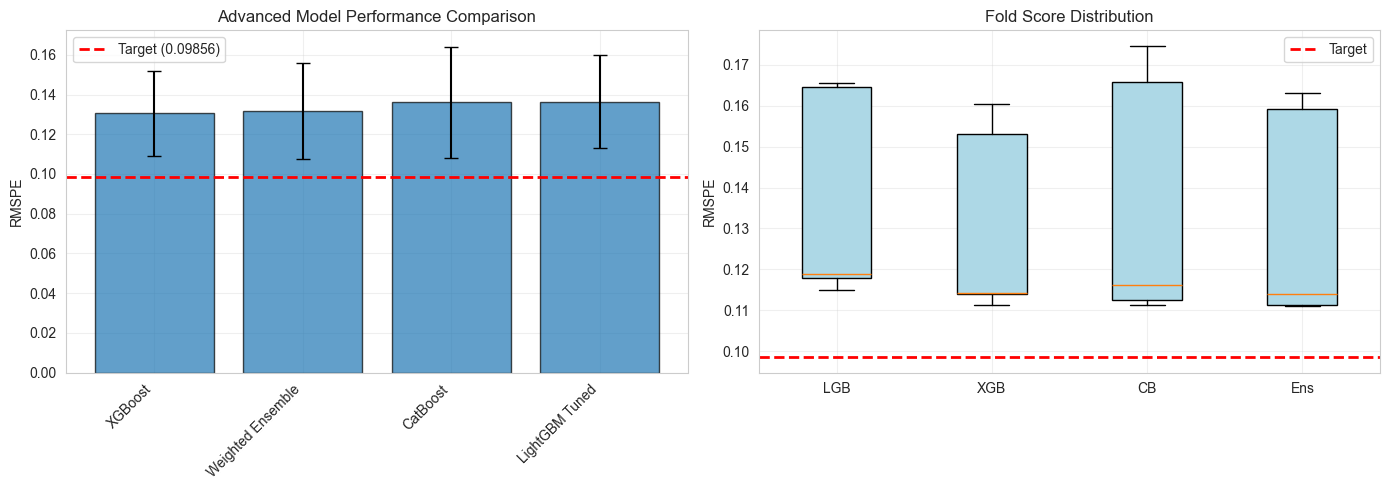

In [14]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of mean RMSPE
ax = axes[0]
models = comparison_df['Model']
means = comparison_df['Mean RMSPE']
stds = comparison_df['Std RMSPE']

ax.bar(range(len(models)), means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('RMSPE')
ax.set_title('Advanced Model Performance Comparison')
ax.axhline(y=0.09856, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3)

# Box plot of fold scores
ax = axes[1]
fold_scores = [
    lgb_tuned_results['fold_scores'],
    xgb_results['fold_scores'],
    cb_results['fold_scores'],
    ensemble_results['fold_scores']
]
bp = ax.boxplot(fold_scores, tick_labels=['LGB', 'XGB', 'CB', 'Ens'], patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_ylabel('RMSPE')
ax.set_title('Fold Score Distribution')
ax.axhline(y=0.09856, color='red', linestyle='--', label='Target', linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Analyze feature importance from the tuned LightGBM model.

In [15]:
# Get feature importance from LightGBM models
importance_list = []

for model in lgb_tuned_results['models']:
    importance = model.feature_importance(importance_type='gain')
    importance_list.append(importance)

# Calculate mean importance across folds
mean_importance = np.mean(importance_list, axis=0)
std_importance = np.std(importance_list, axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': mean_importance,
    'importance_std': std_importance
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

print("\nTop 20 Most Important Features:")
display(feature_importance_df.head(20))


Top 20 Most Important Features:


,feature,importance_mean,importance_std
0,Sales_Lag_14,1.695847e+13,2.066350e+12
1,Sales_RollingMean_7,1.153462e+13,2.148223e+12
2,Sales_RollingStd_7,2.963532e+12,6.646296e+11
3,Sales_Lag_28,2.826236e+12,7.552389e+11
4,Promo,1.985113e+12,2.651102e+11
5,Sales_Lag_1,1.487234e+12,2.210861e+11
6,Sales_RollingMean_14,1.238069e+12,4.742557e+11
7,DayOfWeek,9.820876e+11,2.022617e+11
8,Week,6.660806e+11,7.747010e+10
9,Day,6.564654e+11,6.266702e+10


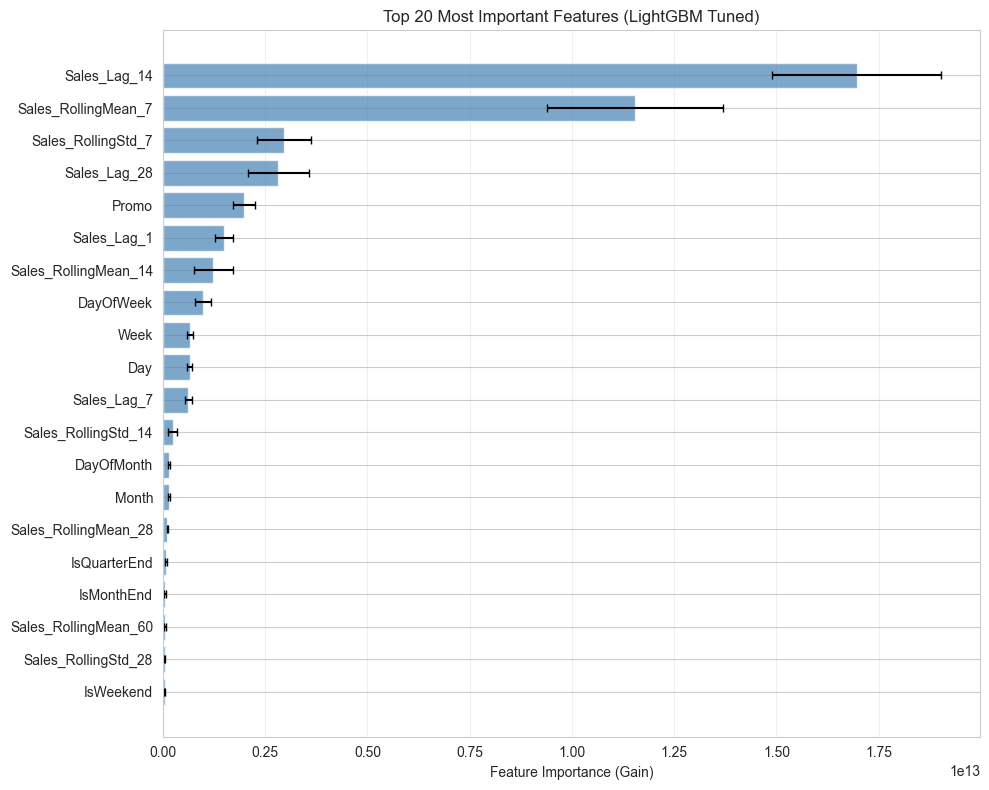

In [16]:
# Visualize top features
top_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance_mean'],
         xerr=top_features['importance_std'], capsize=3, alpha=0.7, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Most Important Features (LightGBM Tuned)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 8. Performance Analysis

In [17]:
print("="*70)
print("ADVANCED MODEL ANALYSIS")
print("="*70)

best_model = comparison_df.iloc[0]
best_score = best_model['Mean RMSPE']
best_name = best_model['Model']

print(f"\nBest Model: {best_name}")
print(f"  Mean RMSPE: {best_score:.6f}")

target_rmspe = 0.09856
gap = best_score - target_rmspe
gap_pct = (gap / target_rmspe) * 100

print(f"\nGap to Target:")
print(f"  Target: {target_rmspe:.6f}")
print(f"  Current: {best_score:.6f}")
print(f"  Gap: {gap:.6f} ({gap_pct:+.2f}%)")

if best_score <= target_rmspe:
    print(f"\n🎯 TARGET ACHIEVED!")
else:
    print(f"\n📊 Additional improvement needed")
    print(f"\nNext steps to reach target:")
    print(f"  - Hyperparameter tuning with Optuna")
    print(f"  - Additional feature engineering")
    print(f"  - Stacked ensemble with meta-learner")

print("="*70)

ADVANCED MODEL ANALYSIS

Best Model: XGBoost
  Mean RMSPE: 0.130598

Gap to Target:
  Target: 0.098560
  Current: 0.130598
  Gap: 0.032038 (+32.51%)

📊 Additional improvement needed

Next steps to reach target:
  - Hyperparameter tuning with Optuna
  - Additional feature engineering
  - Stacked ensemble with meta-learner


## 9. Summary

In [18]:
print("\n" + "="*70)
print("Phase 4 Complete!")
print("="*70)
print("Trained 3 advanced models + weighted ensemble")
print(f"\nBest model: {best_name}")
print(f"Best RMSPE: {best_score:.6f}")
print(f"\nMLflow Tracking:")
print(f"  All experiments tracked in MLflow")
print(f"  View results: bash scripts/start_mlflow.sh")
print(f"  Then open: http://127.0.0.1:5000")
print(f"\nReady for Phase 5: Final Evaluation")
print("="*70)


Phase 4 Complete!
Trained 3 advanced models + weighted ensemble

Best model: XGBoost
Best RMSPE: 0.130598

MLflow Tracking:
  All experiments tracked in MLflow
  View results: bash scripts/start_mlflow.sh
  Then open: http://127.0.0.1:5000

Ready for Phase 5: Final Evaluation
